## Optimizer

Define curtailment possibilities to be imposed

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [39]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot
plt.rcParams.update({'font.size': 22})

In [40]:
os.chdir('/home/MA')

In [41]:
PV_lifetime = 25 #years

In [42]:
elec_battery_prod = 95.5 # kwh_el/kWh_n

In [43]:
PV_size = 6 #kW_p

In [44]:
max_c_charge = 0.25
max_c_discharge = 0.5

Roundtrip efficiency solar battery: 85% (check alternative sources) https://www.homerenergy.com/products/pro/docs/latest/battery_roundtrip_efficiency.html#:~:text=The%20battery%20round%2Dtrip%20efficiency,Typically%20it%20is%20about%2080%25.
Assumption: Losses occur during discharging only (Charging efficiency is 99% https://www.powertechsystems.eu/home/tech-corner/lithium-ion-battery-advantages/)

In [45]:
eta_discharge = 0.85

Emissions of grid mix at consumer level are taken from https://www.bafu.admin.ch/bafu/de/home/themen/klima/klimawandel--fragen-und-antworten.html#:~:text=Die%20Kennzahlen%20f%C3%BCr%20die%20verschiedenen,)%20(relevant%20f%C3%BCr%20volkswirtschaftliche%20Betrachtungen)

In [46]:
battery_lifetime = 15 # years

In [47]:
grid_emissions_CH= 181.5 # g CO2/kWh

Battery production energy intensity from https://www.researchgate.net/publication/331837767_The_energetic_implications_of_introducing_lithium-ion_batteries_into_distributed_photovoltaic_systems

In [48]:
elec_battery_prod = 95.5 # kwh_el/kWh_n

Assumption: Battery production in China
at 637 g CO2/kWh
https://www.mdpi.com/1996-1073/14/4/961/pdf

In [49]:
CO2_intensity_China = 637

In [50]:
PV_production = pd.read_pickle('Calculations/CH/PV_production_CH.pkl')

In [51]:
total_elec_load = pd.read_pickle('Calculations/CH/load_CH_modern_full_retrofit.pkl')

In [52]:
yearly_PV_production = sum(PV_production)

In [53]:
electricity_PV_production = 1597 # kWh_el kWp-1

In [54]:
PV_size = 6 #kW_p

In [55]:
from Battery_dispatch_function import BatteryDispatch

In [56]:
curtailment_thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#curtailment_thresholds = [0.4, 0.5]
battery_size = list(range(0, 25))

In [57]:
pd.options.mode.chained_assignment = None  # default='warn'

results = pd.DataFrame()
results['curtailment'] = curtailment_thresholds
results['optimal_battery_size'] = ''    
results['net_CO2_savings'] = ''
    
for curtailment in curtailment_thresholds:
    
    temp = 0
    max_power_allowed = curtailment*PV_size
    PV_production_used = PV_production.copy()
    PV_production_used[PV_production_used > max_power_allowed] = max_power_allowed
    PV_production_curtailed = PV_production - max_power_allowed
    PV_production_curtailed[PV_production_curtailed < 0] = 0
    power_balance = pd.DataFrame()
    power_balance['consumption'] = total_elec_load
    power_balance['from PV'] = PV_production_curtailed
    power_balance['exchange grid'] = PV_production_curtailed - total_elec_load
    power_balance['to Grid'] = (PV_production_curtailed - total_elec_load).clip(lower=0)
    power_balance['from Grid'] = (total_elec_load - PV_production_curtailed).clip(lower=0)
    power_balance = power_balance.fillna(0)
    
    temp = pd.DataFrame()
    temp['battery_size'] = battery_size
    temp['yearly_savings_kWh'] = ''
    temp['yearly_savings_CO2'] = ''
    temp['total_CO2_grid_reduced'] = ''
    temp['total_CO2_battery_prod'] = ''
    temp['net_CO2_savings'] = ''
    for i in range(0, len(temp['battery_size'])):
        powerbalance = BatteryDispatch(power_balance, temp['battery_size'].values[i], eta_discharge, max_c_charge, max_c_discharge)
        temp['yearly_savings_kWh'].values[i] = -sum(power_balance['Discharging'])
        temp['yearly_savings_CO2'].values[i] = temp['yearly_savings_kWh'].values[i] * grid_emissions_CH / 1000000
        temp['total_CO2_grid_reduced'].values[i] = temp['yearly_savings_CO2'].values[i] * PV_lifetime
        temp['total_elec_battery_prod'] = 2 * (elec_battery_prod * temp['battery_size']/0.8)
        temp['total_CO2_battery_prod'].values[i] = temp['total_elec_battery_prod'].values[i] * CO2_intensity_China / 1000000
        temp['net_CO2_savings'].values[i] =  temp['total_CO2_grid_reduced'].values[i] - temp['total_CO2_battery_prod'].values[i]
    temp_max = temp[temp['net_CO2_savings']==temp['net_CO2_savings'].max()]
    results.optimal_battery_size[results.curtailment == curtailment] = temp_max['battery_size'].values
    results.net_CO2_savings[results.curtailment == curtailment] = temp_max['net_CO2_savings'].values


In [58]:
results.set_index("curtailment",drop=True,inplace=True)

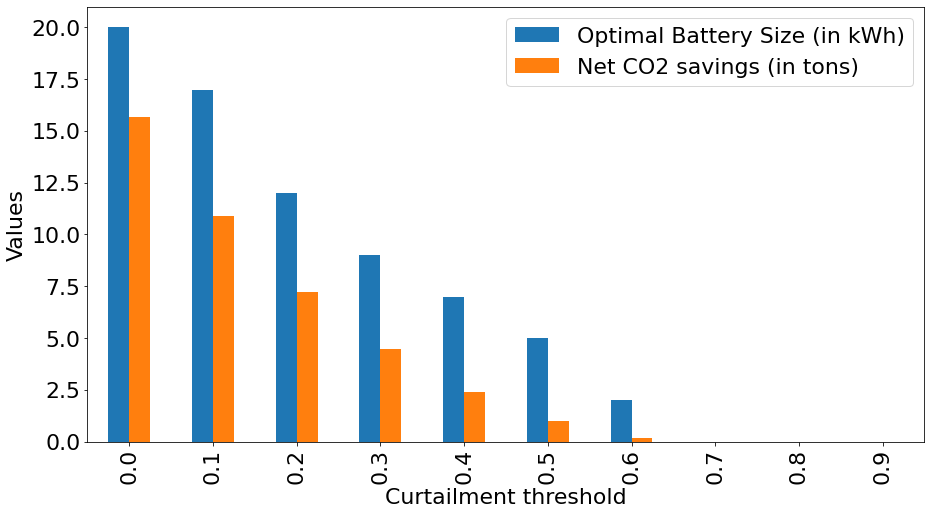

In [59]:
results.rename(columns={"optimal_battery_size": "Optimal Battery Size (in kWh)", "net_CO2_savings": "Net CO2 savings (in tons)"}).plot.bar(xlabel = 'Curtailment threshold', ylabel = 'Values');

In [60]:
#pd.options.mode.chained_assignment = None  # default='warn'
#
#results = pd.DataFrame()
#results['curtailment'] = curtailment_thresholds
#results['optimal_battery_size'] = ''    
#results['net_CO2_savings'] = ''
#    
#for curtailment in curtailment_thresholds:
#    
#    temp = 0
#    max_power_allowed = curtailment*PV_size
#    PV_production_used = PV_production.copy()
#    PV_production_used[PV_production_used > max_power_allowed] = max_power_allowed
#    PV_production_curtailed = PV_production - max_power_allowed
#    PV_production_curtailed[PV_production_curtailed < 0] = 0
#    power_balance = pd.DataFrame()
#    power_balance['consumption'] = total_elec_load
#    power_balance['from PV'] = PV_production_curtailed
#    power_balance['exchange grid'] = PV_production_curtailed - total_elec_load
#    power_balance['to Grid'] = (PV_production_curtailed - total_elec_load).clip(lower=0)
#    power_balance['from Grid'] = (total_elec_load - PV_production_curtailed).clip(lower=0)
#    power_balance = power_balance.fillna(0)
#    
#    temp = pd.DataFrame()
#    temp['battery_size'] = battery_size
#    temp['yearly_savings_kWh'] = ''
#    temp['yearly_savings_CO2'] = ''
#    temp['total_CO2_grid_reduced'] = ''
#    temp['total_CO2_battery_prod'] = ''
#    temp['net_CO2_savings'] = ''
#    temp['curtailment'] = ''
#    temp['stored'] = ''
#    temp['ESOI'] = ''
#    temp['EROI_gen'] = ''
#    temp['EROI_grid_curtailed'] = ''
#    temp['EROI_grid_curtailed'] = ''
#    temp['total_elec_PV_prod'] = electricity_PV_production * PV_size
#    
#    for i in range(0, len(temp['battery_size'])):
#        powerbalance = BatteryDispatch(power_balance, temp['battery_size'].values[i], eta_discharge, max_c_charge, max_c_discharge)
#        temp['curtailment'].values[i] = sum(power_balance['to Grid New'])/sum(power_balance['from PV'])
#        temp['yearly_savings_kWh'].values[i] = -sum(power_balance['Discharging'])
#        temp['total_savings_kWh'] = temp['yearly_savings_kWh'].values[i] * PV_lifetime
#        temp['yearly_savings_CO2'].values[i] = temp['yearly_savings_kWh'].values[i] * grid_emissions_CH / 1000000
#        temp['total_CO2_grid_reduced'].values[i] = temp['yearly_savings_CO2'].values[i] * PV_lifetime
#        temp['total_elec_battery_prod'] = 2 * (elec_battery_prod * temp['battery_size']/0.8)
#        temp['total_CO2_battery_prod'].values[i] = temp['total_elec_battery_prod'].values[i] * CO2_intensity_China / 1000000
#        temp['net_CO2_savings'].values[i] =  temp['total_CO2_grid_reduced'].values[i] - temp['total_CO2_battery_prod'].values[i]
#        temp['stored'].values[i] = temp.iloc[0]['curtailment'] - temp['curtailment'].values[i]
#        temp['ESOI'].values[i] = temp['total_savings_kWh'].div(temp['total_elec_battery_prod'].where(temp['total_elec_battery_prod'] != 0, np.nan))
#        temp['EROI_gen'].values[i] = yearly_PV_production*PV_lifetime/temp['total_elec_PV_prod']
#        temp['EROI_grid_curtailed'].values[i] = (1 - temp['stored'].values[i] + eta_discharge * temp['stored'].values[i])/(1/temp['EROI_gen'].values[i]+temp['stored'].values[i]/temp['ESOI'].values[i])*(1-temp['curtailment'].values[i])
#        temp['EROI_grid_curtailed'].values[i] = temp['EROI_grid_curtailed'].values[i].fillna(temp['EROI_gen'].values[i]*(1-temp['curtailment'].values[i]))
#        temp['ESOI'].values[i] = temp['ESOI'].values[i].fillna(0)
#    temp_max = temp[temp['net_CO2_savings']==temp['net_CO2_savings'].max()]
#    results.optimal_battery_size[results.curtailment == curtailment] = temp_max['battery_size'].values
#    results.net_CO2_savings[results.curtailment == curtailment] = temp_max['net_CO2_savings'].values
    
    #temp_max_eroi = temp[temp['EROI_grid_curtailed']==temp['EROI_grid_curtailed'].max()]
    #results_eroi.optimal_battery_size[results.curtailment == curtailment] = temp_max_eroi['battery_size'].values
    #results_eroi.optimal_battery_size[results.curtailment == curtailment] = temp_max_eroi['battery_size'].values